In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [3]:
train = pd.read_csv(r"C:\Users\ramak\OneDrive\Documents\projects\demand_train.csv", parse_dates = ['order_date'])
train.head()

,order_date,0
0,2016-09-15,1.0
1,2016-09-16,0.0
2,2016-09-17,0.0
3,2016-09-18,0.0
4,2016-09-19,0.0


In [4]:
train = train.set_index('order_date')
train = train['0']
train.head()

order_date
2016-09-15    1.0
2016-09-16    0.0
2016-09-17    0.0
2016-09-18    0.0
2016-09-19    0.0
Name: 0, dtype: float64

In [5]:
test = pd.read_csv(r"C:\Users\ramak\OneDrive\Documents\projects\demand.test.csv", parse_dates = ['order_date'])
test.head()

,order_date,demand
0,2018-04-09,250.0
1,2018-04-10,196.0
2,2018-04-11,262.0
3,2018-04-12,253.0
4,2018-04-13,197.0


In [6]:
test = test.set_index('order_date')
test = test['demand']
test.head()

order_date
2018-04-09    250.0
2018-04-10    196.0
2018-04-11    262.0
2018-04-12    253.0
2018-04-13    197.0
Name: demand, dtype: float64

#### After outlier treatment, the ARIMA(2,1,1) model was re-trained and evaluated on the same test set to assess performance changes. Model selection was finalized based on comparative MAE and RMSE results.

In [8]:
from statsmodels.tsa.arima.model import ARIMA

train = train.asfreq('D')
model = ARIMA(train, order = (2, 1, 1))

# 1. Fit the model
model_fit = model.fit()

# 2. Print the full summary table
print(model_fit.summary())

# 3. Specifically check AIC (Lower is generally better)
print(f"AIC: {model_fit.aic}")

# 4. Check if the model actually converged (mathematically 'settled')
print(f"Converged: {model_fit.mle_retvals['warnflag'] == 0}")

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  571
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2668.865
Date:                Fri, 06 Feb 2026   AIC                           5345.730
Time:                        08:38:05   BIC                           5363.113
Sample:                    09-15-2016   HQIC                          5352.512
                         - 04-08-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6112      0.047     12.929      0.000       0.519       0.704
ar.L2         -0.2528      0.033     -7.631      0.000      -0.318      -0.188
ma.L1         -0.7710      0.036    -21.586      0.0

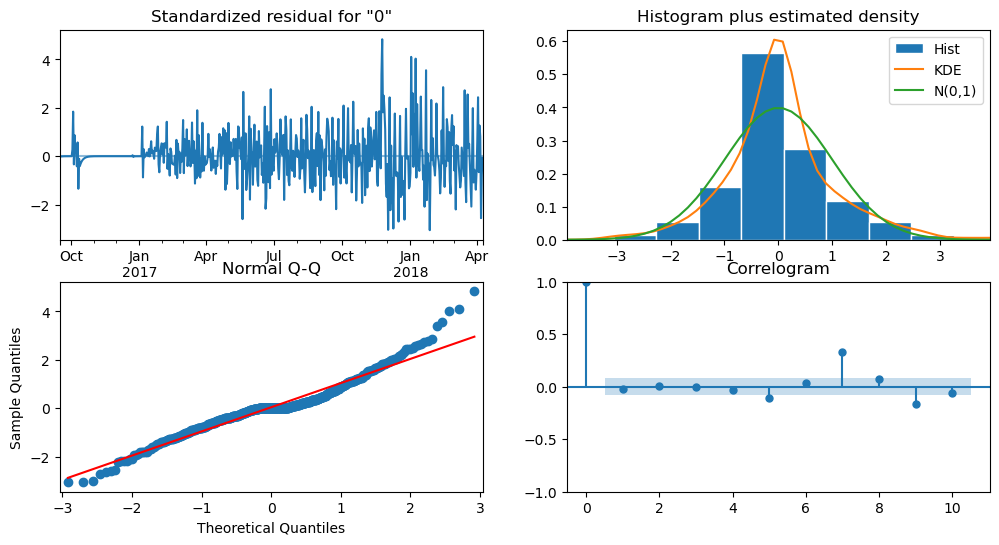

In [9]:
# Generate the 4-plot diagnostic dashboard
fig = model_fit.plot_diagnostics(figsize=(12, 6))
plt.show()

#### Generated out-of-sample forecasts for the test period using the trained ARIMA(2,1,1) model. Forecast accuracy was evaluated using MAE and RMSE, and results were visualized by comparing predicted and actual demand over time.

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Forecast the exact length of the test set
forecast_steps = len(test)
forecast_object = model_fit.get_forecast(steps=forecast_steps)

# 2. Extract the mean forecast and align the index
# This ensures dates match the test set for plotting and metrics
forecast_values = forecast_object.summary_frame()['mean']
forecast_values.index = test.index 

# Optional: Extract confidence intervals for better visualization
conf_int = forecast_object.summary_frame(alpha=0.05) # 95% confidence

In [11]:
# 3. Evaluate performance
mae = mean_absolute_error(test, forecast_values)
rmse = np.sqrt(mean_squared_error(test, forecast_values))

print(f"--- Evaluation Metrics ---")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

--- Evaluation Metrics ---
MAE:  56.9604
RMSE: 70.4494


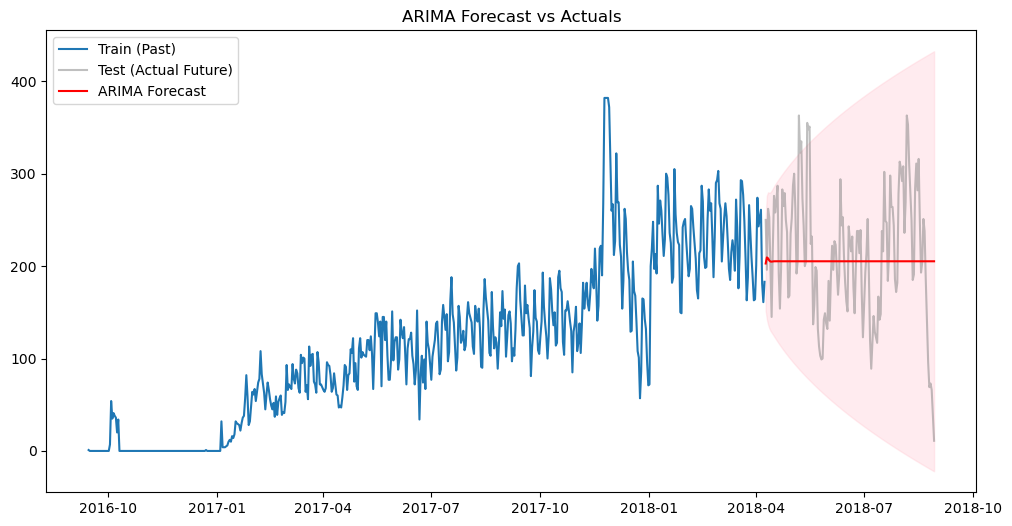

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train (Past)')
plt.plot(test.index, test, label='Test (Actual Future)', color='gray', alpha=0.5)
plt.plot(forecast_values.index, forecast_values, label='ARIMA Forecast', color='red')

# Shade the confidence interval
plt.fill_between(forecast_values.index, 
                 conf_int['mean_ci_lower'], 
                 conf_int['mean_ci_upper'], 
                 color='pink', alpha=0.3)

plt.title("ARIMA Forecast vs Actuals")
plt.legend()
plt.show()